# Training of vision model to identify the 100 selected plant species


In [1]:
from fastai.vision.all import *
import timm
import torch

/home/kenneth/anaconda3/envs/fastai/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Define directories
data_dir = Path("../data")
img_dir = data_dir/"images_preproc"
model_dir = data_dir/"model"

In [3]:
len(get_image_files(img_dir))

24721

In [4]:
#Define function to get dataloader with different image and batch size
def get_dls(bs, size):
    dl = ImageDataLoaders.from_folder(
        path = img_dir, 
        valid_pct = 0.2, 
        bs = bs, 
        item_tfms = Resize(460),
        batch_tfms = aug_transforms(mult=2,size=size, min_scale=0.25))
    return(dl)

In [5]:
#Get dataloader with lower resolution images for first round of training
#Second round of training will use higher resolution images (progressive resizing)
dls = get_dls(64, 300)

In [6]:
#Use model from the timm library
#Here we use a pretrained light-weight efficientnet
learn = vision_learner(dls, 
                       "efficientnet_b0",
                       pretrained=False,
                       cbs=[MixUp(1.)],
                       loss_func=LabelSmoothingCrossEntropy(), #CrossEntropyLossFlat
                       metrics=[accuracy, top_k_accuracy]).to_fp16()

In [7]:
#plantnet weights
#https://github.com/plantnet/PlantNet-300K/blob/main/utils.py
plantnet = torch.load(model_dir/"efficientnet_b0_weights_best_acc.tar", map_location="cpu")
plantnet_state_dict = plantnet["model"]
plantnet_state_dict.pop('classifier.weight')
plantnet_state_dict.pop('classifier.bias')

#replace names in state_dict
new_state_dict = OrderedDict()

for k, v in plantnet_state_dict.items():
    name = "model."+k
    new_state_dict[name] = v

#update learner model weights
learn.model[0].load_state_dict(new_state_dict)


<All keys matched successfully>

In [8]:
#First round of training
learn.fine_tune(5, 2e-3, freeze_epochs=2)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,4.342415,2.542483,0.499798,0.779935,01:26
1,3.786499,2.265203,0.563511,0.830097,01:25


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.491731,2.085367,0.628439,0.861448,01:38
1,3.390505,2.054395,0.647856,0.861246,01:38
2,3.284396,1.939914,0.680623,0.882484,01:38
3,3.194346,1.877381,0.701254,0.892395,01:38
4,3.164252,1.848534,0.708333,0.896036,01:37


In [10]:
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.158264,1.851861,0.708940,0.897047,01:36
1,3.155819,1.855540,0.708333,0.893406,01:37
2,3.165705,1.843584,0.711772,0.897654,01:37
3,3.157251,1.880848,0.700647,0.890979,01:36
4,3.151434,1.893428,0.697209,0.888754,01:36


In [11]:
#Save model
learn.path = model_dir
learn.export("effnet_b0_13122022.export")

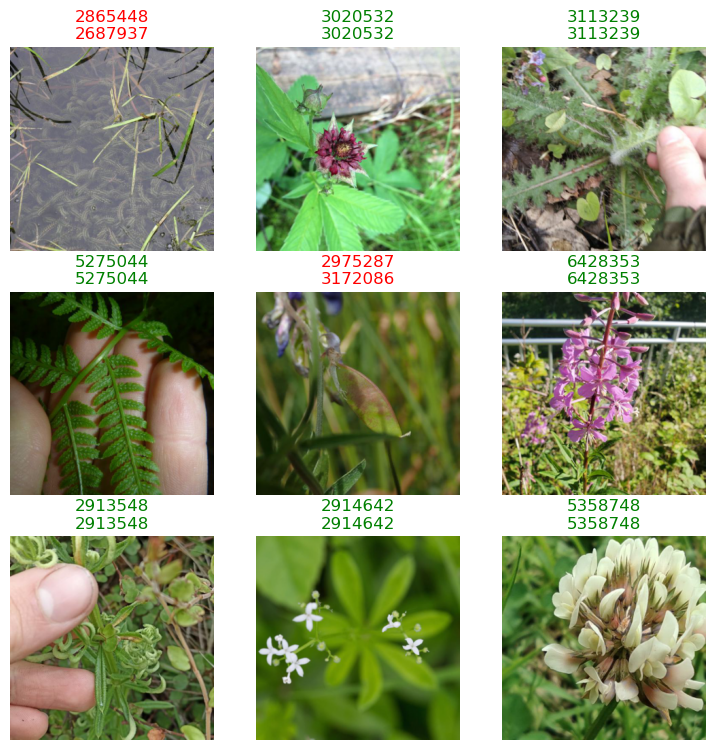

In [12]:
#Show example classifications
learn.show_results()